## **Final Project 2 (Klasifikasi gambar)**

## Mengunduh dan menyiapkan dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset
train_dir = '/content/drive/MyDrive/hb74ynkjcn-5'

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Menyiapkan data (Preprocessing Data)

['Pongamia Pinnata (P7)', 'Pomegranate (P9)', 'Jatropha (P6)', 'Jamun (P5)', 'Chinar (P11)', 'Basil (P8)', 'Gauva (P3)', 'Lemon (P10)', 'Bael (P4)', 'Mango (P0)', 'Arjun (P1)', 'Alstonia Scholaris (P2)']
Found 3608 images belonging to 12 classes.
Found 894 images belonging to 12 classes.


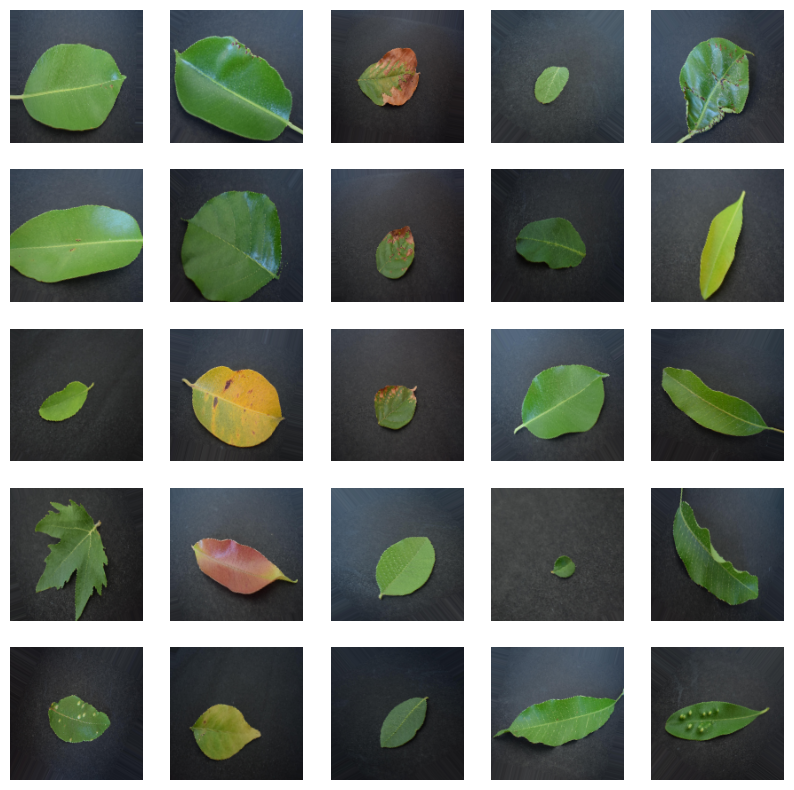

Found 4502 images belonging to 12 classes.
Found 4502 images belonging to 12 classes.


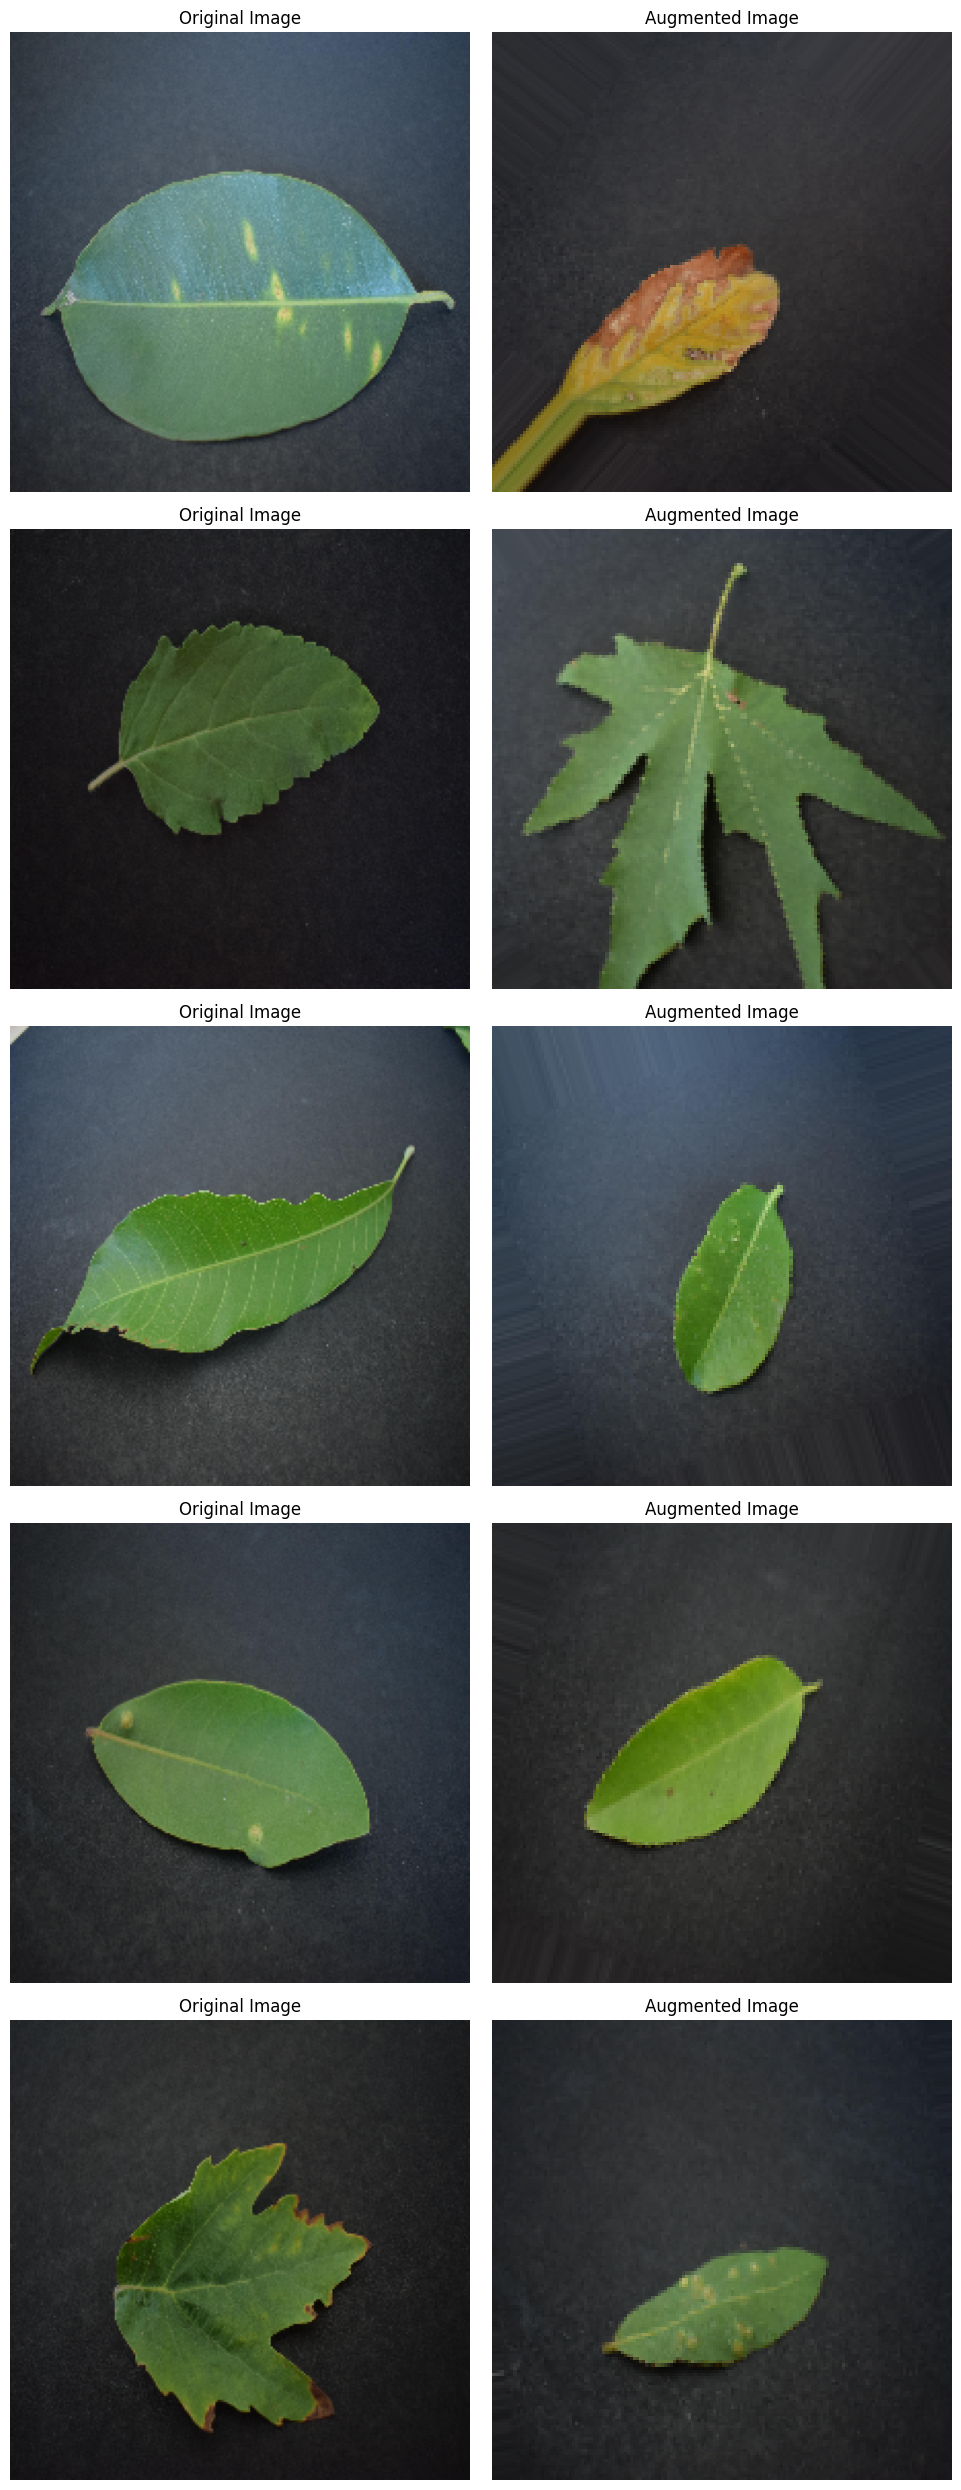

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Memeriksa struktur direktori
print(os.listdir(train_dir))

# ImageDataGenerator untuk augmentasi gambar
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   validation_split=0.2)  # Membagi data untuk validasi

# Data generator untuk training dan validasi
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    subset='training')  # Set untuk training

valid_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    subset='validation')  # Set untuk validasi

# Ambil beberapa sampel gambar secara acak dari generator
sample_images, _ = next(train_generator)

# Menampilkan 25 gambar secara acak
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')  # Menghilangkan sumbu x dan y
plt.show()


# Inisialisasi ImageDataGenerator tanpa augmentasi untuk visualisasi data asli
original_datagen = ImageDataGenerator(rescale=1./255)

# Initialize ImageDataGenerator with augmentation for augmented data visualization
augmented_datagen = ImageDataGenerator(
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
rotation_range=40,
)

# Load beberapa contoh gambar dari dataset asli
original_data_generator = original_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=True
)

# Load some example images from the augmented dataset
augmented_data_generator = augmented_datagen.flow_from_directory(
    train_dir,  # Use the same directory as original for augmentation
    target_size=(150, 150),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode=None,
    shuffle=True
)
# Visualisasi beberapa contoh gambar sebelum dan sesudah augmentasi
num_images = 5

plt.figure(figsize=(10, 5*num_images))

# Visualisasi data asli
for i in range(num_images):
    original_image = next(original_data_generator)[0]
    plt.subplot(num_images, 2, 2*i+1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

# Visualize augmented data
for i in range(num_images):
    augmented_image = next(augmented_data_generator)[0]
    plt.subplot(num_images, 2, 2*i+2)
    plt.imshow(augmented_image)
    plt.title('Augmented Image')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Membangun model CNN (Convolutional Neural Network)

In [ ]:
model = Sequential()
##layer pertama convolutional dan maxpooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
##layer kedua convolutional dan maxpooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
##layer ketiga convolutional dan maxpooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
##layer mengubah nilai multidimensional menjadi satu dimensi
model.add(Flatten())
##layer fully connected
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
##layer output
model.add(Dense(12, activation='softmax'))  # Ada 120 kelas dalam dataset Stanford Dogs

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## Melatih Model

In [ ]:
# Callbacks untuk early stopping dan model checkpoint
##early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) ##untuk melakukan stop pelatihan jika selama pelatihan sejumlah patience, model tidak membaik
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1) ## menyimpan model terbaik berdasarkan val_loss yang membaik

# Melatih model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples // valid_generator.batch_size,
                    epochs=30,
                    ##callbacks=[early_stopping, model_checkpoint]
                    )


Epoch 1/30
56/56 [==============================] - 2329s 41s/step - loss: 2.0422 - accuracy: 0.2757 - val_loss: 1.6133 - val_accuracy: 0.4087
Epoch 2/30
56/56 [==============================] - 818s 15s/step - loss: 1.3030 - accuracy: 0.5621 - val_loss: 1.1703 - val_accuracy: 0.6202
Epoch 3/30
56/56 [==============================] - 817s 15s/step - loss: 1.0107 - accuracy: 0.6696 - val_loss: 0.9602 - val_accuracy: 0.6695
Epoch 4/30
56/56 [==============================] - 817s 15s/step - loss: 0.8159 - accuracy: 0.7348 - val_loss: 0.8986 - val_accuracy: 0.6911
Epoch 5/30
56/56 [==============================] - 879s 16s/step - loss: 0.6860 - accuracy: 0.7740 - val_loss: 0.9256 - val_accuracy: 0.6863
Epoch 6/30
56/56 [==============================] - 892s 16s/step - loss: 0.5973 - accuracy: 0.8039 - val_loss: 0.7955 - val_accuracy: 0.7512
Epoch 7/30
56/56 [==============================] - 837s 15s/step - loss: 0.4955 - accuracy: 0.8375 - val_loss: 1.1047 - val_accuracy: 0.6923
Epoch

## Evaluasi Model

13/13 [==============================] - 145s 11s/step - loss: 0.7823 - accuracy: 0.8173
Validation Accuracy: 81.73%


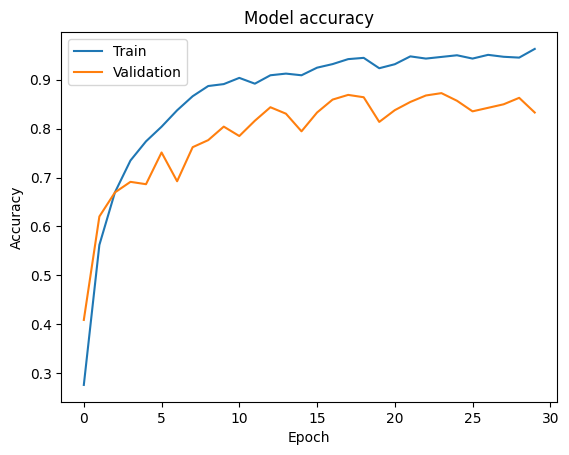

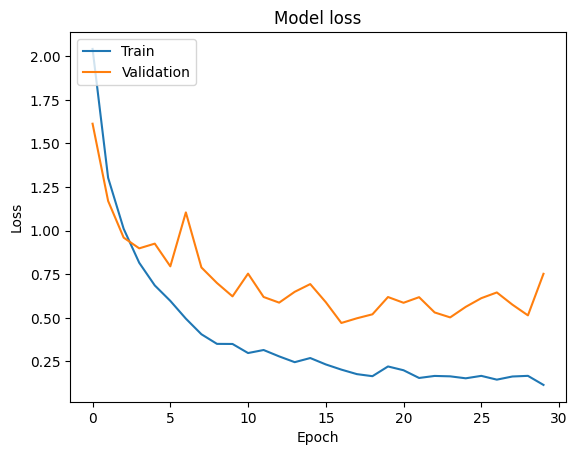

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Test Akurasi Model Klasifikasi 50 Gambar

13/13 [==============================] - 129s 10s/step - loss: 0.7746 - accuracy: 0.8173
Validation Accuracy: 81.73%
2/2 [==============================] - 1s 196ms/step


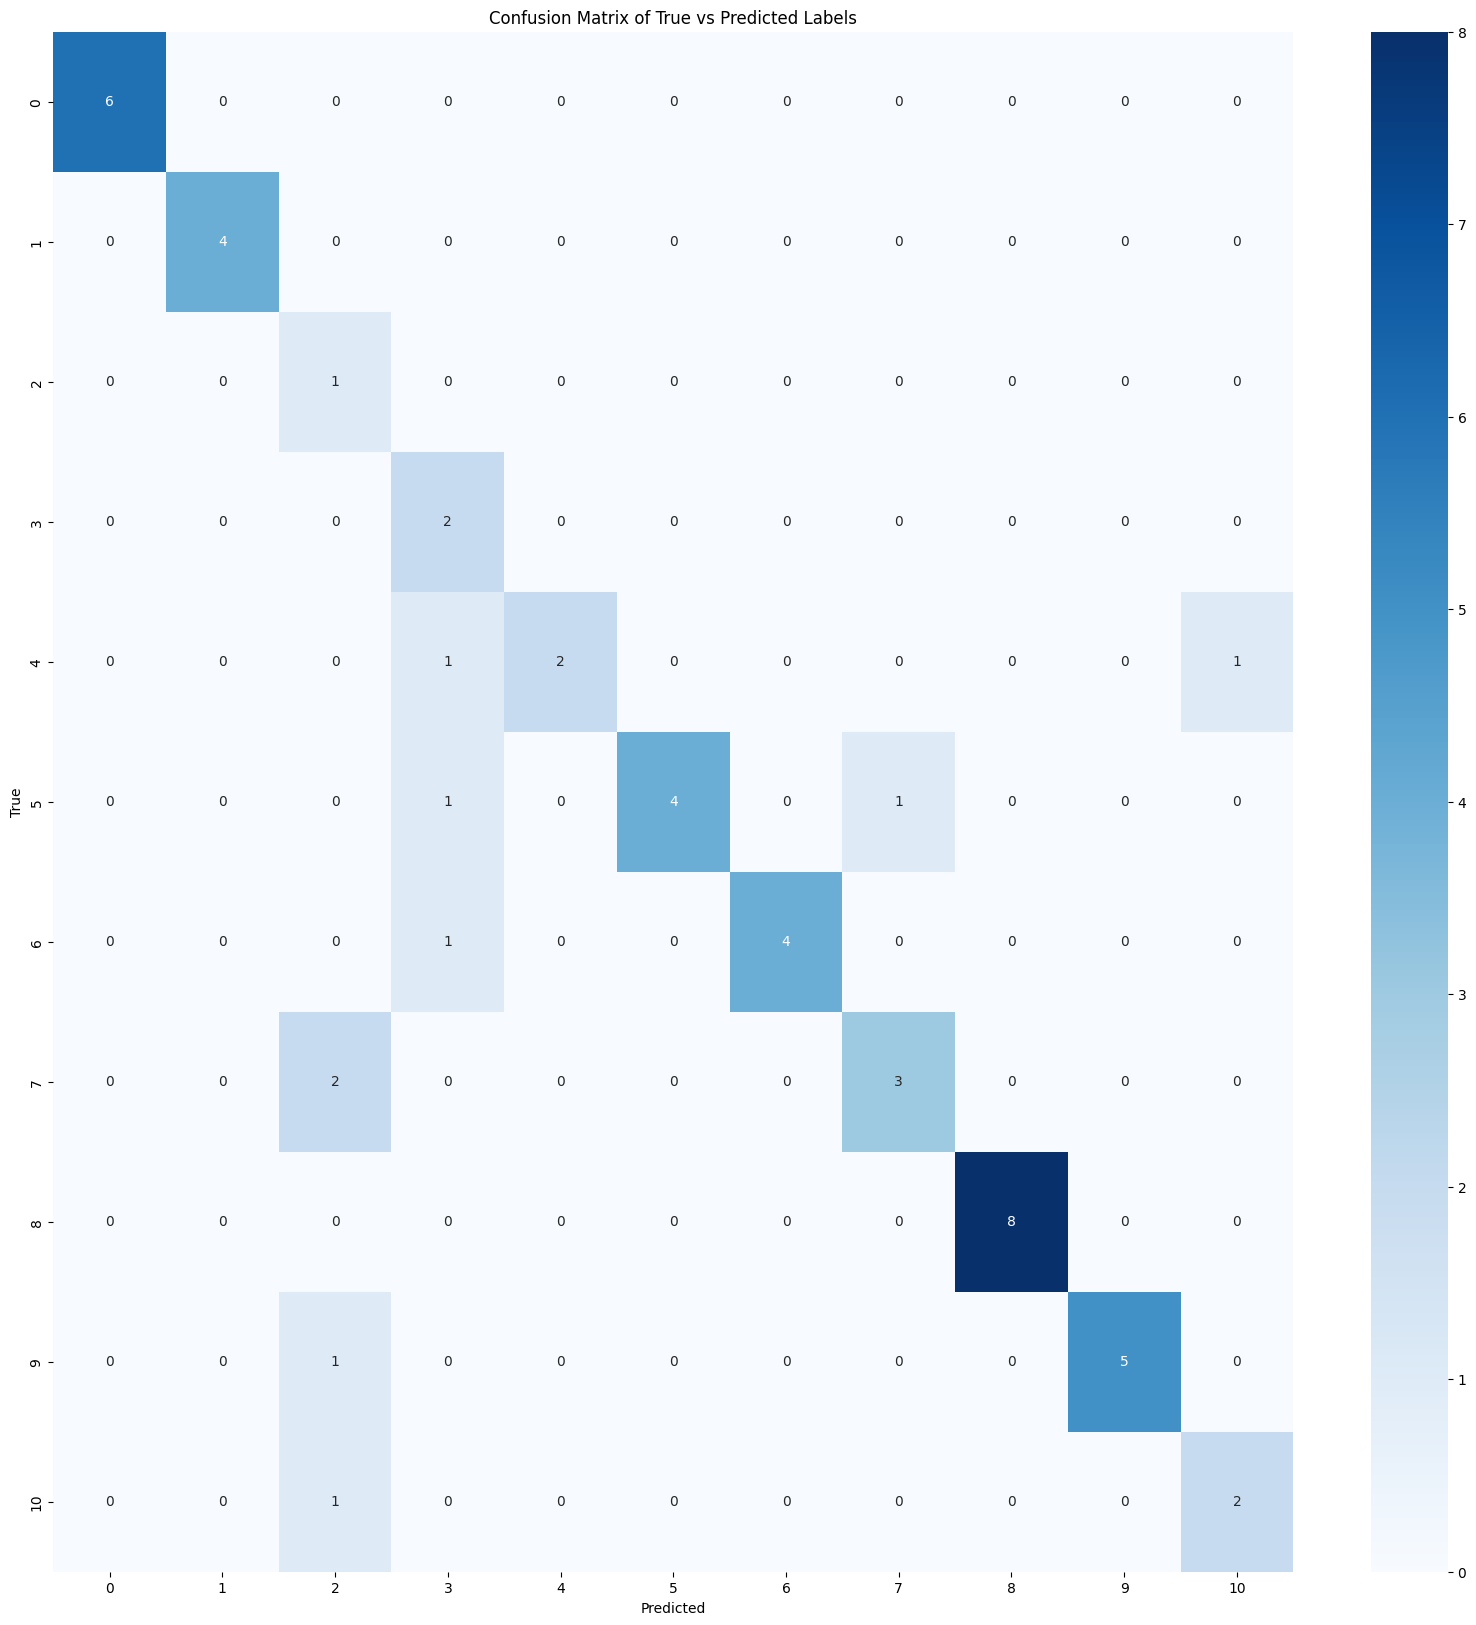

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           3       0.20      1.00      0.33         1
           4       0.40      1.00      0.57         2
           5       1.00      0.50      0.67         4
           6       1.00      0.67      0.80         6
           7       1.00      0.80      0.89         5
           8       0.75      0.60      0.67         5
           9       1.00      1.00      1.00         8
          10       1.00      0.83      0.91         6
          11       0.67      0.67      0.67         3

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.77        50
weighted avg       0.92      0.82      0.84        50



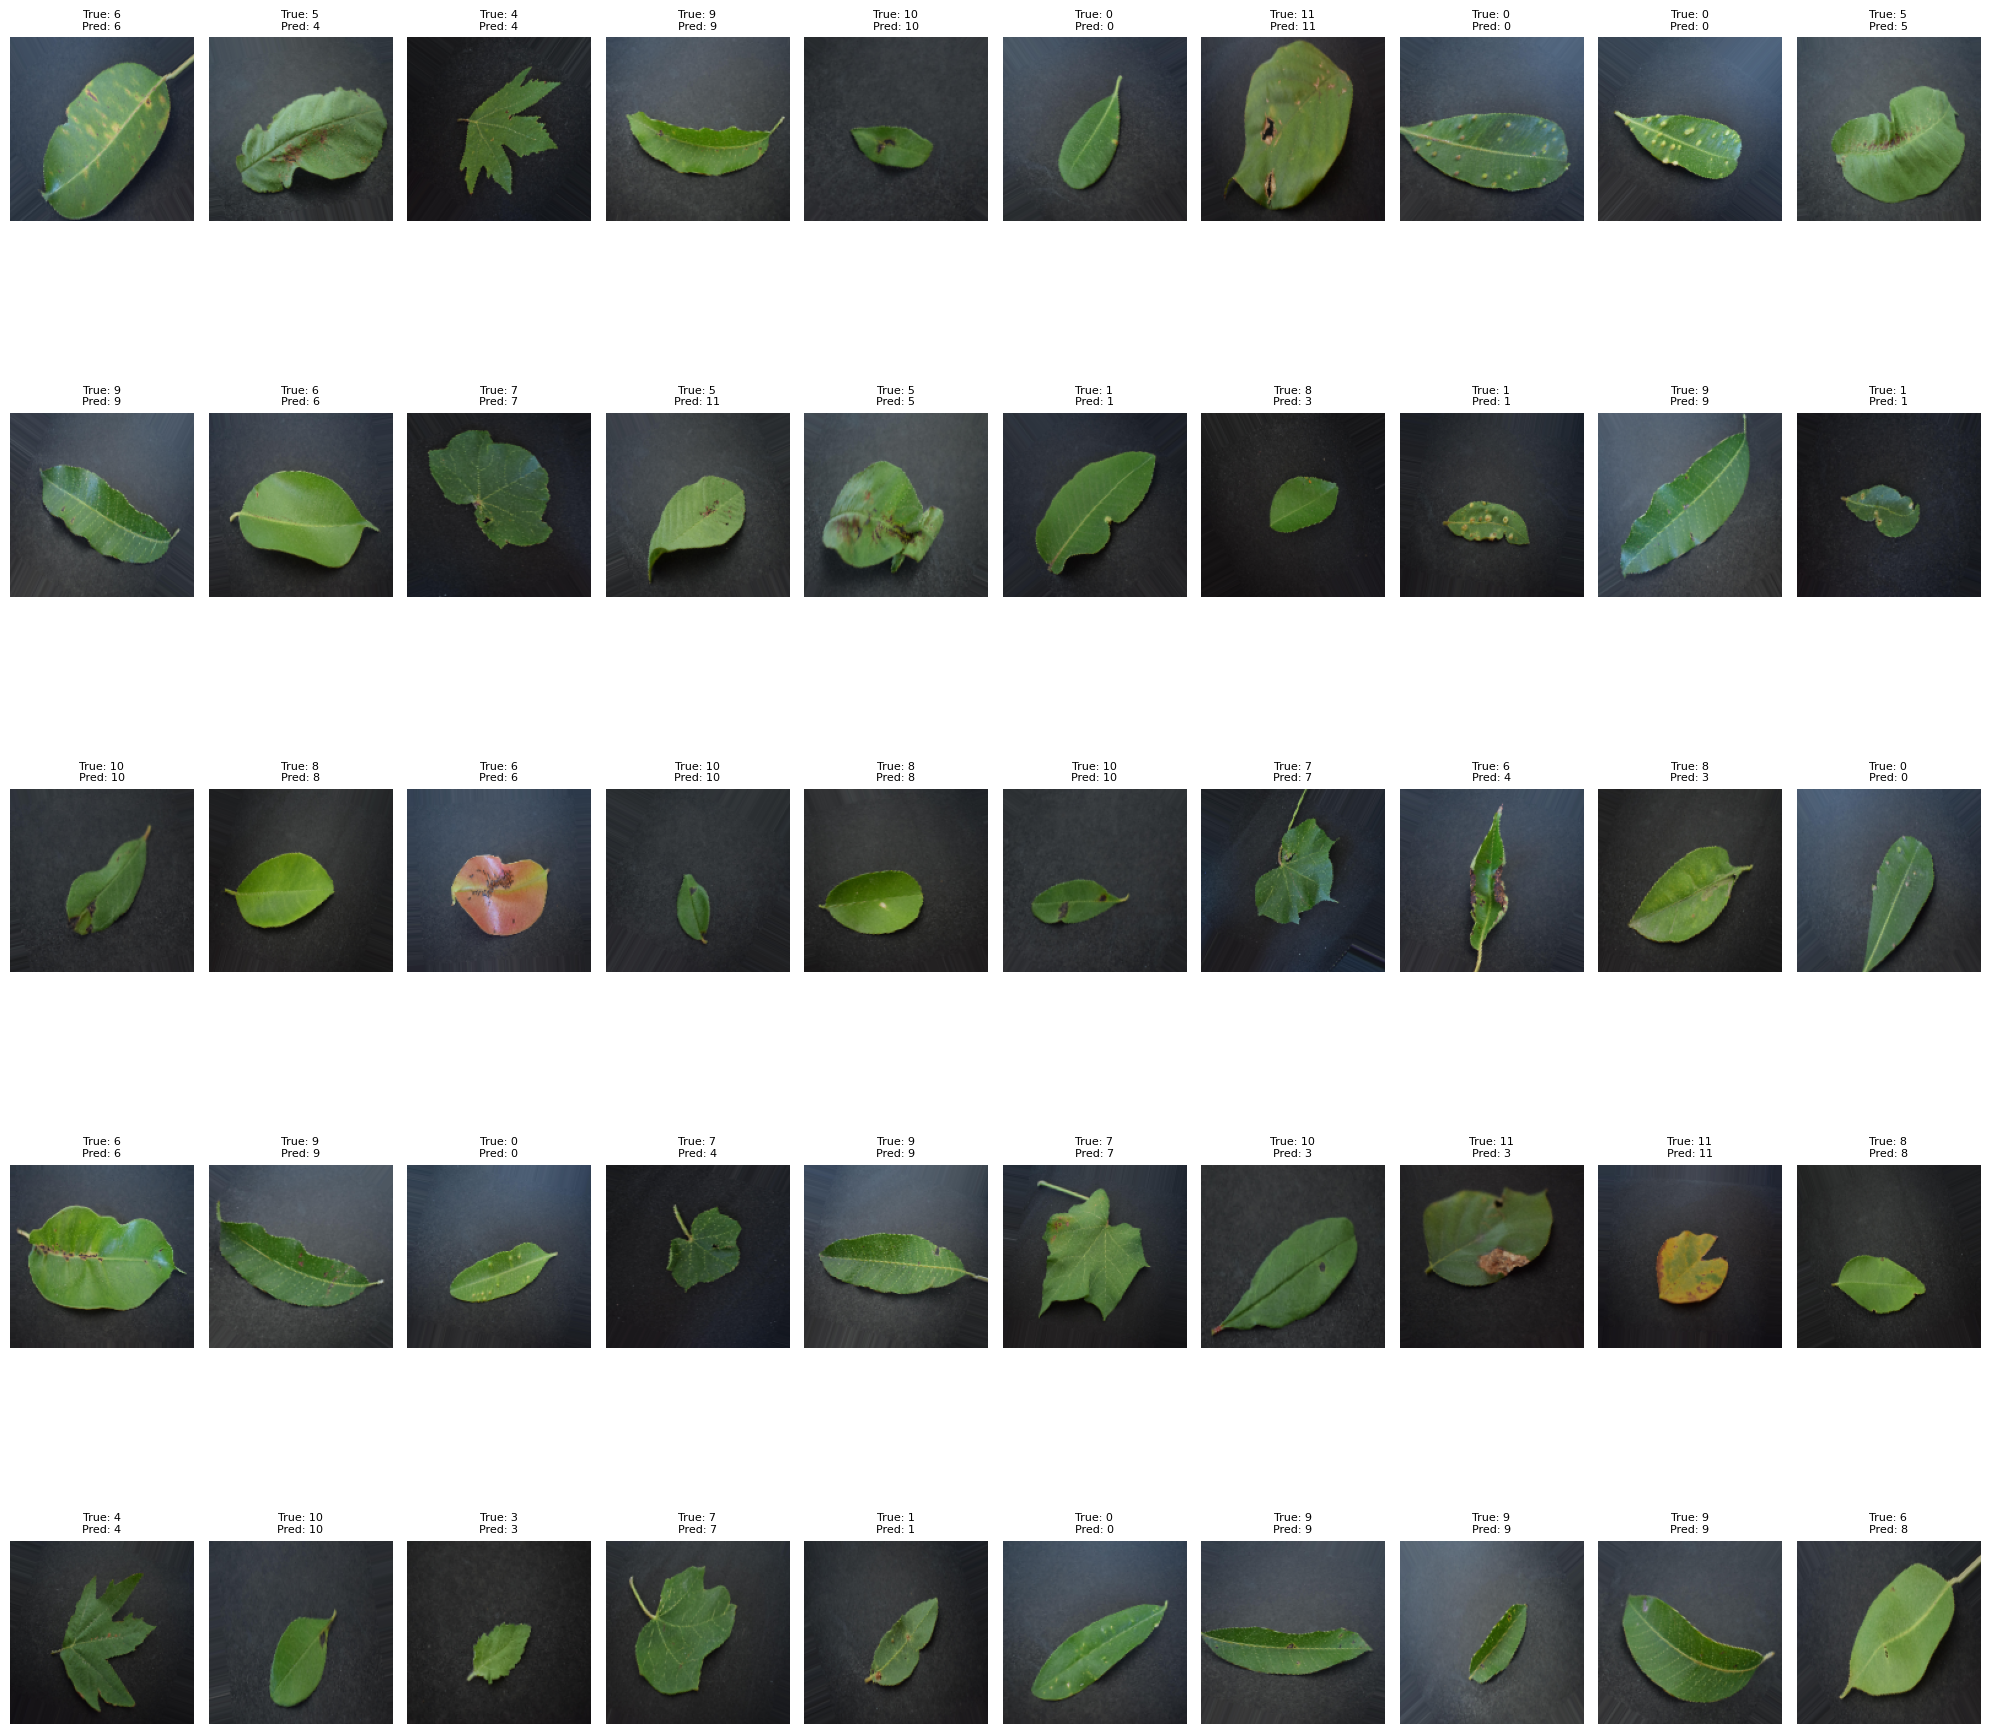

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Langkah 1: Ambil 50 gambar dari validasi generator
valid_generator.reset()  # Reset generator untuk memastikan prediksi dari awal

# Evaluasi model pada data validasi
loss, accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

x_batch, y_true = next(valid_generator)  # Ambil batch pertama
x_sample, y_sample = x_batch[:50], y_true[:50]  # Ambil 50 gambar pertama

# Langkah 2: Lakukan prediksi
y_pred_prob = model.predict(x_sample)  # Prediksi probabilitas kelas
y_pred = np.argmax(y_pred_prob, axis=1)  # Ambil kelas dengan probabilitas tertinggi
y_true = np.argmax(y_sample, axis=1)  # Konversi label one-hot ke label kelas

# Langkah 3: Tampilkan persebaran True vs Predicted
# Tampilkan confusion matrix menggunakan seaborn heatmap
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of True vs Predicted Labels')
plt.show()

# Tampilkan classification report
print(classification_report(y_true, y_pred))  # Tidak perlu menyertakan target_names di sini

# Opsional: Tampilkan beberapa gambar dengan prediksi dan label aslinya
fig, axes = plt.subplots(5, 10, figsize=(20, 20))
axes = axes.flatten()
for img, true_label, pred_label, ax in zip(x_sample, y_true, y_pred, axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=8)
plt.tight_layout()
plt.show()
